# Using RetrieveChat Powered by Couchbase Capella for Retrieve Augmented Code Generation and Question Answering

This tutorial will show you how we've made building Retrieval-Augmented Generation (RAG) applications much easier with Couchbase and AG2. By leveraging Couchbase's Search vector index for storing and retrieving document embeddings, along with AG2's powerful AI capabilities, our integration simplifies the entire process. As part of this tutorial, we'll also build a demo application where an AI agent can answer questions based on documentation links provided for any framework. This hands-on approach will demonstrate how effortlessly you can create intelligent, context-aware AI applications using this integration.

RetrieveChat is a conversational system for retrieval-augmented code generation and question answering. In this notebook, we demonstrate how to utilize RetrieveChat to generate code and answer questions based on customized documentations that are not present in the LLM's training dataset. RetrieveChat uses the `AssistantAgent` and `RetrieveUserProxyAgent`, which is similar to the usage of `AssistantAgent` and `UserProxyAgent` in other notebooks (e.g., [Automated Task Solving with Code Generation, Execution & Debugging](https://docs.ag2.ai/docs/use-cases/notebooks/notebooks/agentchat_auto_feedback_from_code_execution)). Essentially, `RetrieveUserProxyAgent` implement a different auto-reply mechanism corresponding to the RetrieveChat prompts.

Some extra dependencies are needed for this notebook, which can be installed via pip

In [ ]:
!git clone -b couchbase_integration https://github.com/VirajAgarwal1/ag2_couchbase.git

In [ ]:
!pip install beautifulsoup4 langchain chromadb ag2[retrievechat-couchbase]
!pip install ./ag2_couchbase/
# For more information, please refer to the [installation guide](/docs/installation/).

## Environment Setup

Before we proceed with the notebook, we will require a Couchbase Capella Database Cluster running.  

- To set up a free operational cluster, head over to [Couchbase Cloud](https://cloud.couchbase.com) and create an account. There, create a free cluster. For more details on creating a cluster, [refer here](https://docs.couchbase.com/cloud/get-started/create-account.html).  

- After creating the cluster, we need to create our required bucket, scope, and collections. Head over to **Data Tools**. On the left-hand side panel, you will find an option to create a bucket. Assign appropriate names for the Bucket, Scope, and Collection. For this tutorial, use the following:  
    - **Bucket Name**: `new_bucket`  
    - **Scope Name**: `new_scope`  
    - **Collection Name**: `new_collection`  
    - **Vector SearchIndex Name**: `vector_index`

- **Create a Search Index:**  Before proceeding further, we need to set up a search index for vector-based retrieval. This is essential for efficient querying in our RAG pipeline. Follow the steps below:  

    1. **Navigate to the Search Tab:**  
        - In the Couchbase UI, go to the **Search** tab.  
        - Click on the **Create Index** button.  

    2. **Enable Advanced Mode:**  
        - Ensure that **Advanced Mode** is enabled to configure type mappings properly.  

    3. **Choose Bucket, Scope, and Collection:**  
        - Select the **Bucket, Scope, and Collection** where your documents and their embeddings will be uploaded.  

    4. **Add Collection to Index:**  
        - In the **Configured Type Mappings** section, ensure the collection is added to the index.  

    5. **Configure Type Mappings:**  
        - Click on the **Add Field** button to define fields for indexing.  

    6. **Add a Mapping for the Vector Field:**  
        - Create a new field for the vector embeddings.  
        - The **field name** should generally be **`embedding`**.  
        - The **searchable as** name should match the field name (`embedding`), as this is how the search index will identify it.  
        - Set the **type** to "vector".  
        - Specify the **dimension** of the embedding model you are using:  
            - **SentenceTransformers & OpenAI embeddings:** `384`.  

    7. **Add a Mapping for the Context Field:**  
        - Add another field for the text associated with the embedding.  
        - The **field name** should generally be **`content`**.  
        - Set the **type** to "text" to enable full-text search capabilities on the stored context.  

    8. **Create the Index:**  
        - Name your index `vector_index`
        - Click the **Create Index** button at the bottom to finalize the configuration.  

- Now, we will connect to the cluster. [Refer to this page for connection details](https://docs.couchbase.com/cloud/get-started/connect.html).  

- **Create a user to connect:**  
  - Navigate to the **Settings** tab.  
  - Click **Create Cluster Access** and specify a username and password.  
  - Assign **read/write access to all buckets** (you may create more users with restricted permissions as needed).  
  - For more details, [refer here](https://docs.couchbase.com/cloud/clusters/manage-database-users.html#create-database-credentials).  

- **Add an IP Address to the allowed list:**  
  - In **Settings**, click on **Networking**.  
  - Add an [allowed IP](https://docs.couchbase.com/cloud/clusters/allow-ip-address.html) based on your requirements.  

- **Set up environment variables:**  
  Retrieve the connection string from the **Connect** tab. Then, configure the following environment variables:  
    - `CB_CONN_STR`: Couchbase Cluster Connection String  
    - `CB_USERNAME`: Username of the created user  
    - `CB_PASSWORD`: Password of the created user  
    - `OPENAI_API_KEY`: OpenAI API Key (required for agents)

In [ ]:
import os
# Environment Variables
os.environ["CB_CONN_STR"] = "<<CONNECTION_STRING_TO_YOUR_CLUSTER>>"
os.environ["CB_USERNAME"] = "<<CLUSTER_ACCESS_USERNAME>>"
os.environ["CB_PASSWORD"] = "<<CLUSTER_ACCESS_PASSWORD>>"
os.environ["OPENAI_API_KEY"] = "<<OPENAI_API_KEY>>"

**Voila! Your cluster is now ready to be used.**

## Initializing Agents

We start by initializing the `AssistantAgent` and `RetrieveUserProxyAgent`. The system message needs to be set to "You are a helpful assistant." for AssistantAgent. The detailed instructions are given in the user message. Later we will use the `RetrieveUserProxyAgent.message_generator` to combine the instructions and a retrieval augmented generation task for an initial prompt to be sent to the LLM assistant.

In [ ]:
import os
import sys

from autogen import AssistantAgent

sys.path.append(os.path.abspath("/workspaces/autogen/autogen/agentchat/contrib"))

from autogen.agentchat.contrib.retrieve_user_proxy_agent import RetrieveUserProxyAgent

# Accepted file formats for that can be stored in
# a vector database instance
from autogen.retrieve_utils import TEXT_FORMATS

config_list = [{"model": "gpt-4o", "api_key": os.environ["OPENAI_API_KEY"], "api_type": "openai"}]
assert len(config_list) > 0
print("models to use: ", [config_list[i]["model"] for i in range(len(config_list))])

In [ ]:
print("Accepted file formats for `docs_path`:")
print(TEXT_FORMATS)

### Understanding `AssistantAgent` in AutoGen  

The `AssistantAgent` in AutoGen is a specialized subclass of `ConversableAgent` designed to perform tasks using large language models (LLMs). By default, it generates code suggestions and debugging assistance but does not execute code autonomously; it relies on user intervention for code execution.

**Key Components of the `AssistantAgent` Initialization:**

- **`name`**: Assigns a unique identifier to the agent.

- **`system_message`**: Sets the default behavior and role of the agent. In this case, it's initialized with "You are a helpful assistant," guiding the agent to provide assistance aligned with this directive.

- **`llm_config`**: Configures the LLM's behavior with parameters like timeout settings, caching mechanisms, and a list of model configurations (`config_list`).

**How `AssistantAgent` Operates:**

Once initialized, the `AssistantAgent` can interact with users or other agents to process tasks. It leverages the specified LLM configurations to generate responses, code snippets, or debugging advice based on the input it receives. However, it does not execute code by default, awaiting user approval or execution commands.

For more detailed information, refer to the official AG2 documentation on [`AssistantAgent`](https://docs.ag2.ai/docs/api-reference/autogen/AssistantAgent).  

### Implementing `AssistantAgent` for LLM-Powered Assistance

The provided code snippet demonstrates the creation of an `AssistantAgent` instance named "assistant" using the AutoGen framework. The `AssistantAgent` class is designed to interact with large language models (LLMs) to solve tasks, including suggesting Python code blocks and debugging. By default, it does not execute code and expects the user to handle code execution.

- **`name="assistant"`**: Assigns the name "assistant" to the agent.

- **`system_message="You are a helpful assistant."`**: Sets a system message that defines the assistant's role and behavior during interactions.

- **`llm_config={...}`**: Provides configuration settings for the LLM:
  - **`timeout=600`**: Specifies a timeout of 600 seconds for LLM responses.
  - **`cache_seed=42`**: Sets a seed value for caching mechanisms to ensure consistent results.
  - **`config_list=config_list`**: Includes a list of additional configurations, which can define specific LLM models or parameters to use.

By default, the `AssistantAgent` has `human_input_mode` set to "NEVER" and `code_execution_config` set to `False`, meaning it doesn't execute code and doesn't require human input during interactions.  

In [ ]:
# 1. create an AssistantAgent instance named "assistant"
assistant = AssistantAgent(
    name="assistant",
    system_message="You are a helpful assistant.",
    llm_config={
        "timeout": 600,
        "cache_seed": 42,
        "config_list": config_list,
    },
)

## Fetching Documentation

The following function recursively fetches all unique internal links from the given documentation URL within a specified time limit. This is useful for gathering documentation pages that will be used to augment the LLM's responses.

In [ ]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse
import time
import os
from concurrent.futures import ThreadPoolExecutor, as_completed

def get_documentation_links(base_url, visited=None, start_time=None, time_limit=10):
    """
    Recursively fetch all unique internal links from the given documentation URL with a time constraint.

    Args:
        base_url (str): The URL of the documentation homepage.
        visited (set): A set to keep track of visited URLs.
        start_time (float): The start time of execution.
        time_limit (int): The maximum time allowed for execution in seconds.

    Returns:
        list: A list of unique internal links found in the documentation.
    """
    if visited is None:
        visited = set()
    if start_time is None:
        start_time = time.time()

    # Stop recursion if time limit is exceeded
    if time.time() - start_time > time_limit:
        return list(visited)

    try:
        response = requests.get(base_url, timeout=5)
        response.raise_for_status()
    except requests.RequestException as e:
        print(f"Error fetching the page: {e}")
        return list(visited)

    soup = BeautifulSoup(response.text, "html.parser")
    domain = urlparse(base_url).netloc

    links = set()
    for a_tag in soup.find_all("a", href=True):
        href = a_tag["href"].strip()
        full_url = urljoin(base_url, href)
        parsed_url = urlparse(full_url)

        if parsed_url.netloc == domain and full_url not in visited:  # Ensure it's an internal link within the same domain
            visited.add(full_url)
            links.add(full_url)
            links.update(get_documentation_links(full_url, visited, start_time, time_limit))  # Recursive call with time check

    return list(visited)


In [ ]:
def fetch_content_generators(links, num_workers=5):
    """
    Splits the links into separate lists for each worker and returns generators for each worker.
    Extracts only plain text from HTML before yielding.

    Args:
        links (list): List of URLs to fetch content from.
        num_workers (int): Number of workers, each receiving a distinct set of links.

    Returns:
        list: A list of generators, one for each worker.
    """
    def fetch_content(sub_links):
        for link in sub_links:
            try:
                response = requests.get(link, timeout=5)
                response.raise_for_status()

                # Extract plain text from HTML
                soup = BeautifulSoup(response.text, "html.parser")
                text_content = soup.get_text()

                yield link, text_content
            except requests.RequestException as e:
                print(f"Error fetching {link}: {e}")
                yield link, None

    # Split links into chunks for each worker
    chunk_size = (len(links) + num_workers - 1) // num_workers  # Ensure even distribution
    link_chunks = [links[i:i + chunk_size] for i in range(0, len(links), chunk_size)]

    return [fetch_content(chunk) for chunk in link_chunks]

In [ ]:
def save_content_to_files(links, output_folder="docs_data", num_workers=5):
    """
    Uses fetch_content_generators to fetch content in parallel and save it to local files.

    Args:
        links (list): List of URLs to fetch content from.
        output_folder (str): Folder to store the saved text files.
        num_workers (int): Number of workers for parallel processing.

    Returns:
        list: A list of file paths where content is saved.
    """
    os.makedirs(output_folder, exist_ok=True)
    generators = fetch_content_generators(links, num_workers=num_workers)

    file_paths = []

    def process_and_save(gen, worker_id):
        local_paths = []
        for j, (url, content) in enumerate(gen):
            if content:  # Avoid saving empty or failed fetches
                file_name = f"doc_{worker_id}_{j}.txt"
                file_path = os.path.join(output_folder, file_name)
                with open(file_path, "w", encoding="utf-8") as f:
                    f.write(content)
                local_paths.append(file_path)
        return local_paths

    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = {executor.submit(process_and_save, gen, i): i for i, gen in enumerate(generators)}
        for future in as_completed(futures):
            file_paths.extend(future.result())

    return file_paths

### 📌 Input Documentation Link Here
Please enter the link to the documentation below.  

In [ ]:
default_link = "https://docs.ag2.ai/docs/use-cases/notebooks/Notebooks"
main_doc_link = input(f"Enter documentation link: ") or default_link
print("Selected link:", main_doc_link)

In [ ]:
docs_links = get_documentation_links(main_doc_link, None, None, 5)
docs_file_paths = save_content_to_files(docs_links, "./docs", 12)

In [ ]:
len(docs_file_paths), len(docs_links)

## Using RetrieveChat

The `RetrieveUserProxyAgent` in AutoGen is a specialized agent designed to facilitate retrieval-augmented generation (RAG) by leveraging external knowledge sources, typically a vector database. It acts as an intermediary between the user and an AI assistant, ensuring that relevant context is retrieved and supplied to the assistant for more informed responses.



### **How RetrieveUserProxyAgent Works**


1. **Query Processing & Context Retrieval**  
   When the user submits a question, the `RetrieveUserProxyAgent` first determines if the available context is sufficient. If not, it retrieves additional relevant information from an external knowledge base (e.g., a vector database) using similarity search.

2. **Interaction with the Assistant**  
   Once the relevant context is retrieved, the agent forwards both the user's query and the retrieved context to the `AssistantAgent` (such as an OpenAI-based model). This step ensures that the assistant generates an informed and contextually accurate response.

3. **Handling Responses**  
   - If the assistant's response satisfies the user, the conversation ends.  
   - If the response is unsatisfactory or additional context is needed, the agent updates the context and repeats the retrieval process.

4. **User Feedback & Iteration**  
   - The user can provide feedback, request refinements, or terminate the interaction.  
   - If updates are needed, the agent refines the context and interacts with the assistant again.

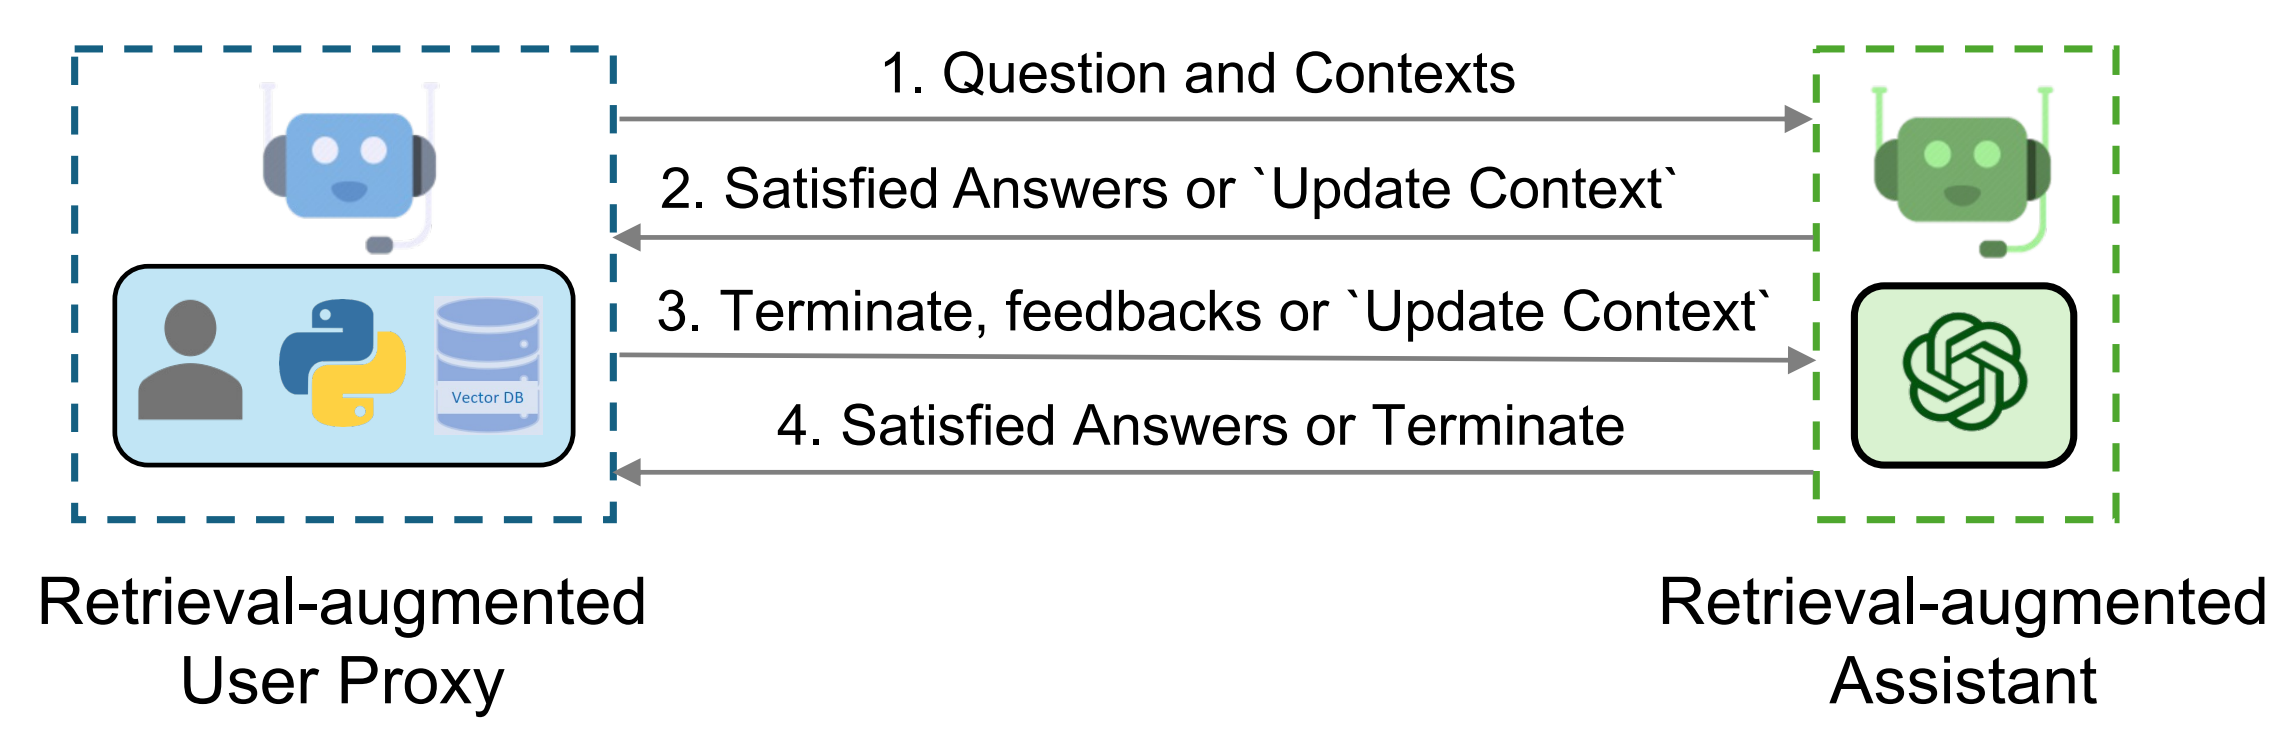

Source: [Retrieval-Augmented Generation (RAG) Applications with AutoGen](https://microsoft.github.io/autogen/0.2/blog/2023/10/18/RetrieveChat/)

### **Configuring `RetrieveUserProxyAgent` with Custom Text Splitting and OpenAI Embeddings for RAG**  

This code snippet demonstrates how to configure a `RetrieveUserProxyAgent` in AutoGen with a custom text splitter and an OpenAI-based embedding function for retrieval-augmented generation (RAG). It utilizes `RecursiveCharacterTextSplitter` to break documents into structured chunks for better embedding and retrieval.  

The embedding function is set up using OpenAI's `text-embedding-3-small` model, but users can alternatively use the default **SentenceTransformers** embedding model. The `RetrieveUserProxyAgent` is then initialized with a predefined task, auto-reply constraints, and a document retrieval path, enabling it to fetch relevant context dynamically and generate accurate responses in an automated workflow.

In [ ]:
from chromadb.utils import embedding_functions
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Initialize a recursive character text splitter with specified separators
recur_spliter = RecursiveCharacterTextSplitter(separators=["\n", "\r", "\t"])

# Option 1: Using OpenAI Embeddings
openai_ef = embedding_functions.OpenAIEmbeddingFunction(
    api_key=os.environ["OPENAI_API_KEY"],
    model_name="text-embedding-3-small",
)

ragproxyagent = RetrieveUserProxyAgent(
    name="ragproxyagent",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=2,
    retrieve_config={
        "task": "code",
        "docs_path": docs_file_paths,
        "chunk_token_size": 1200,  # Defines chunk size for document splitting
        "model": config_list[0]["model"],
        "vector_db": "couchbase",  # Using Couchbase Capella VectorDB
        "collection_name": "new_collection",  # Collection name in Couchbase
        "db_config": {
            "connection_string": os.environ["CB_CONN_STR"],  # Connection string for Couchbase
            "username": os.environ["CB_USERNAME"],  # Couchbase username
            "password": os.environ["CB_PASSWORD"],  # Couchbase password
            "bucket_name": "new_bucket",  # Bucket name in Couchbase
            "scope_name": "new_scope",  # Scope name in Couchbase
            "index_name": "vector_index",  # Index name in Couchbase
        },
        "get_or_create": True,  # Set to False to avoid reusing an existing collection
        "overwrite": False,  # Set to True to overwrite an existing collection (forces index recreation)

        # Option 1: Use OpenAI embedding function (Uncomment below to enable)
        "embedding_function": openai_ef,

        # Option 2: Default embedding model (SentenceTransformers 'all-mpnet-base-v2')
        # "embedding_model": "all-mpnet-base-v2",  # Default model if OpenAI embeddings are not used

        # Custom text splitter function
        "custom_text_split_function": recur_spliter.split_text,
    },
    code_execution_config=False,  # Set to True if you want to execute retrieved code
)

## Chat Interaction

This section marks the beginning of the chat interaction using RetrieveChat powered by Couchbase Capella for Retrieve Augmented Code Generation and Question Answering in AG2.

### Example 1

Use RetrieveChat to help generate sample code and automatically run the code and fix errors if there is any.

Problem: How to use RetrieveChat Powered by Couchbase Capella for Retrieve Augmented Code Generation and Question Answering in AG2?

Note: You may need to create an index on the cluster to query

In [ ]:
assistant.reset()
code_problem = "How to use RetrieveChat Powered by Couchbase Capella for Retrieve Augmented Code Generation and Question Answering in AG2?"
chat_result = ragproxyagent.initiate_chat(assistant, message=ragproxyagent.message_generator, problem=code_problem)